# Data Preprocessing

In [3]:
# import dependancies
import cv2
import os
import numpy as np
from keras.utils import np_utils

data_path='dataset'
categories=os.listdir(data_path)
labels=[i for i in range(len(categories))]

label_dict=dict(zip(categories,labels)) #empty dictionary

print(label_dict)
print(categories)
print(labels)

{'with_mask': 0, 'without_mask': 1}
['with_mask', 'without_mask']
[0, 1]


In [4]:
img_size=100
data=[]
target=[]


for category in categories:
    folder_path=os.path.join(data_path,category)
    img_names=os.listdir(folder_path)
        
    for img_name in img_names:
        img_path=os.path.join(folder_path,img_name)
        img=cv2.imread(img_path)

        try:
            #Coverting the image into gray scale
            gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)           
            #resizing the gray scale into 50x50, since we need a fixed common size for all the images in the dataset
            resized=cv2.resize(gray,(img_size,img_size))
            #appending the image and the label(categorized) into the list (dataset)
            data.append(resized)
            target.append(label_dict[category])
            
        except Exception as e:
            #if any exception rasied, the exception will be printed here. And pass to the next image
            print('Exception:',e)
            

In [5]:
# Create a numpy array to store data and target
data=np.array(data)/255.0
data=np.reshape(data,(data.shape[0],img_size,img_size,1))
target=np.array(target)

# use the keras utils tool to create catagorical target
new_target=np_utils.to_categorical(target)

In [4]:
np.save('numpy/data')
np.save('numpy/target',new_target)

# Training the Convolutional Neural Network

In [6]:
#loading in the saved numpy arrays in the previous code

data=np.load('numpy/data.npy')
target=np.load('numpy/target.npy')


In [7]:
from keras.models import Sequential
from keras.layers import Dense,Activation,Flatten,Dropout
from keras.layers import Conv2D,MaxPooling2D
from keras.callbacks import ModelCheckpoint

model=Sequential()
#The first CNN layer followed by Relu and MaxPooling layers
model.add(Conv2D(200,(3,3),input_shape=data.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

#The second convolution layer followed by Relu and MaxPooling layers
model.add(Conv2D(100,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

#Flatten layer to stack the output convolutions from second convolution layer
model.add(Flatten())
model.add(Dropout(0.5))

#Dense layer of 64 neurons
model.add(Dense(50,activation='relu'))
#The Final layer with two outputs for two categories
model.add(Dense(2,activation='softmax'))


model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [7]:
from sklearn.model_selection import train_test_split

# Use the train_test_split to split the data into training and testing set.
# The data set isnt very large so only using 10% to test. 
train_data,test_data,train_target,test_target=train_test_split(data,target,test_size=0.1)

In [8]:
checkpoint = ModelCheckpoint('Model_Checkpoints/model-{epoch:03d}.model',monitor='val_loss',verbose=0,save_best_only=True,mode='auto')
history=model.fit(train_data,train_target,epochs=20,callbacks=[checkpoint],validation_split=0.2)

Epoch 1/20
31/31 [==============================] - ETA: 0s - loss: 0.6985 - accuracy: 0.5394WARNING:tensorflow:From /Users/serrano/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/training/tracking/tracking.py:111: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: Model_Checkpoints/model-001.model/assets
31/31 [==============================] - 21s 680ms/step - loss: 0.6985 - accuracy: 0.5394 - val_loss: 0.6280 - val_accuracy: 0.6935
Epoch 2/20
31/31 [==============================] - 22s 702ms/step - loss: 0.5490 - accuracy: 0.7525 - val_loss: 0.4289 - val_accuracy: 0.8065
Epoch 3/20
31/31 [==============================] - 23s 754ms/step

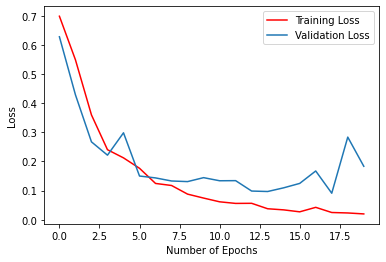

<Figure size 432x288 with 0 Axes>

In [14]:
from matplotlib import pyplot as plt

plt.plot(history.history['loss'],'r',label='Training Loss')
plt.plot(history.history['val_loss'],label='Validation Loss')
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('resources/loss.png')
plt.show()

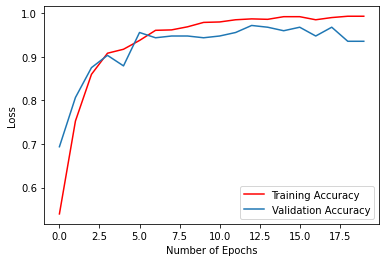

<Figure size 432x288 with 0 Axes>

In [15]:
plt.plot(history.history['accuracy'],'r',label='Training Accuracy')
plt.plot(history.history['val_accuracy'],label='Validation Accuracy')
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('resources/accuracy.png')
plt.show()

In [16]:
print(model.evaluate(test_data,test_target))

5/5 [==============================] - 1s 106ms/step - loss: 0.1363 - accuracy: 0.9420
[0.13628549873828888, 0.9420289993286133]







# Detecting Masks

In [1]:
from keras.models import load_model
import cv2

# load in once of the well performing models from the checkpoints directory.
model = load_model('Model_Checkpoints/model-014.model')
# Load in the face detection classifier for CV2
face_clsfr=cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
# Input of 0 refers to default webcam
source=cv2.VideoCapture(0)

# Label and color in RGB for the frame
labels_dict={0:'THANK YOU!',1:'PUT MASK ON'}
color_dict={0:(0,255,0),1:(0,0,255)}

In [2]:
while(True):

    ret,img=source.read()
    gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    faces=face_clsfr.detectMultiScale(gray,1.3,5)  

    for (x,y,w,h) in faces:
        
        # Find face, resize the shape, pass into model
        face_img=gray[y:y+w,x:x+w]
        resized=cv2.resize(face_img,(100,100))
        normalized=resized/255.0
        reshaped=np.reshape(normalized,(1,100,100,1))
        result=model.predict(reshaped)

        label=np.argmax(result,axis=1)[0]
        
        # Draw the rectangle around the face of the person in frame
        # Passed in the color and text dicts from the previous cell
        cv2.rectangle(img,(x,y),(x+w,y+h),color_dict[label],2)
        cv2.rectangle(img,(x,y-40),(x+w,y),color_dict[label],-1)
        cv2.putText(img, labels_dict[label], (x, y-10),cv2.FONT_HERSHEY_SIMPLEX,0.8,(255,255,255),2)
        
        
    cv2.imshow('LIVE',img)
    key=cv2.waitKey(1)
    
    # if esc key is pressed break out of the loop
    if(key==27):
        break
# Close video window        
cv2.destroyAllWindows()
source.release()